# Recommendation Systems Assignment

### MIE451/1513 UofT

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=efecec19dd26617a5334ebd98c85fd470a91644b40ccb4f62f7b1920557308c0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [20]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [21]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [22]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [23]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [24]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [25]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    
    ###########         end         ###########
    return matrix

In [26]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [27]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
         ##if rating == 0:
            # select the row for user
            # what's the shape of userVector
            userVector = train_matrix[user, :]
            
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))       


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]
            
        # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [28]:
popularity_recsys = BaseLineRecSys('popularity')

In [29]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [32]:
x=popularity_recsys.getModel()

In [33]:
np.all(x<=1)

True

In [34]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()


0it [00:00, ?it/s]
144it [00:00, 1432.38it/s]
269it [00:00, 1369.67it/s]
406it [00:00, 1367.87it/s]
551it [00:00, 1389.36it/s]
696it [00:00, 1404.23it/s]
824it [00:00, 1364.42it/s]
964it [00:00, 1373.06it/s]
1104it [00:00, 1379.04it/s]
1246it [00:00, 1388.59it/s]
1380it [00:01, 1349.55it/s]
1514it [00:01, 1344.25it/s]
1651it [00:01, 1350.05it/s]
1790it [00:01, 1359.72it/s]
1930it [00:01, 1370.70it/s]
2073it [00:01, 1386.78it/s]
2215it [00:01, 1394.51it/s]
2355it [00:01, 1389.47it/s]
2494it [00:01, 1361.33it/s]
2631it [00:01, 1319.81it/s]
2772it [00:02, 1344.75it/s]
2907it [00:02, 1342.16it/s]
3048it [00:02, 1359.52it/s]
3187it [00:02, 1367.30it/s]
3336it [00:02, 1400.36it/s]
3482it [00:02, 1416.30it/s]
3633it [00:02, 1440.91it/s]
3782it [00:02, 1453.24it/s]
3928it [00:02, 1454.83it/s]
4074it [00:02, 1454.24it/s]
4220it [00:03, 1449.69it/s]
4366it [00:03, 1441.85it/s]
4511it [00:03, 1434.35it/s]
4658it [00:03, 1443.93it/s]
4804it [00:03, 1447.76it/s]
4954it [00:03, 1460.85it/s]
5103it 

,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [35]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [36]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [37]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()


0it [00:00, ?it/s]
151it [00:00, 1508.07it/s]
309it [00:00, 1528.62it/s]
459it [00:00, 1519.91it/s]
606it [00:00, 1503.16it/s]
767it [00:00, 1531.07it/s]
922it [00:00, 1536.19it/s]
1078it [00:00, 1540.57it/s]
1235it [00:00, 1548.15it/s]
1388it [00:00, 1541.32it/s]
1547it [00:01, 1554.55it/s]
1699it [00:01, 1515.81it/s]
1848it [00:01, 1485.60it/s]
1995it [00:01, 1477.00it/s]
2142it [00:01, 1433.80it/s]
2299it [00:01, 1470.11it/s]
2457it [00:01, 1499.35it/s]
2616it [00:01, 1524.63it/s]
2773it [00:01, 1537.15it/s]
2929it [00:01, 1541.63it/s]
3090it [00:02, 1559.09it/s]
3249it [00:02, 1565.46it/s]
3406it [00:02, 1539.67it/s]
3564it [00:02, 1549.11it/s]
3720it [00:02, 1513.48it/s]
3880it [00:02, 1537.14it/s]
4035it [00:02, 1540.63it/s]
4196it [00:02, 1557.81it/s]
4352it [00:02, 1547.63it/s]
4513it [00:02, 1563.29it/s]
4672it [00:03, 1568.42it/s]
4831it [00:03, 1574.17it/s]
4989it [00:03, 1568.11it/s]
5151it [00:03, 1582.21it/s]
5310it [00:03, 1571.22it/s]
5468it [00:03, 1556.80it/s]
5628it

,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [41]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix=1/(1+pairwise_distances(matrix, metric='euclidean'))
        
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        similarity_matrix=1/(1+pairwise_distances(matrix, metric='manhattan'))

    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
                # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.transpose() #(943, 1682) to 1682,943
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer==0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.transpose() #1682,943 back to 943,1682


            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [42]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [43]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [44]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Cosine similarity works better than euclidean distance as cosine simliarity measures the angle between vectors instead of the distance which accounts for scalar multiplication of the vectors.

### (b)

In [ ]:
"""third metric implenmented is manhattan distance。 It calculates the absolute
coordinate distance between two vactors. Another reason we want to implement 
manhattan distance is that our vectors will have many dimensions. ANd manhattan
distance will give us more robust results and less error due to outliers since its
gradient's magnitude is constant"""

"third metric implenmented is manhattan distance。 It calculates the absolute\ncoordinate distance between two vactors. Another reason we want to implement \nmanhattan distance is that our vectors will have many dimensions. ANd manhattan\ndistance will give us more robust results and less error due to outliers since its\ngradient's magnitude is constant"

## Q3

### (a)

In [45]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [46]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [47]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [48]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()


0it [00:00, ?it/s]
113it [00:00, 1128.15it/s]
238it [00:00, 1160.98it/s]
355it [00:00, 1162.48it/s]
488it [00:00, 1205.72it/s]
623it [00:00, 1243.24it/s]
756it [00:00, 1266.02it/s]
884it [00:00, 1267.56it/s]
1010it [00:00, 1264.73it/s]
1138it [00:00, 1266.39it/s]
1270it [00:01, 1279.97it/s]
1403it [00:01, 1293.23it/s]
1535it [00:01, 1299.78it/s]
1664it [00:01, 1294.24it/s]
1796it [00:01, 1301.19it/s]
1926it [00:01, 1292.81it/s]
2055it [00:01, 1288.47it/s]
2189it [00:01, 1302.61it/s]
2325it [00:01, 1317.15it/s]
2463it [00:01, 1334.35it/s]
2597it [00:02, 1300.45it/s]
2730it [00:02, 1307.83it/s]
2868it [00:02, 1326.10it/s]
3006it [00:02, 1340.83it/s]
3144it [00:02, 1350.08it/s]
3281it [00:02, 1355.74it/s]
3421it [00:02, 1366.46it/s]
3559it [00:02, 1369.26it/s]
3697it [00:02, 1371.02it/s]
3835it [00:02, 1370.19it/s]
3973it [00:03, 1344.79it/s]
4108it [00:03, 1308.79it/s]
4241it [00:03, 1313.22it/s]
4374it [00:03, 1317.86it/s]
4506it [00:03, 1306.93it/s]
4638it [00:03, 1309.17it/s]
4774it 

,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [49]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

item_cosine_recsys.predict_all(rating_df, num_users, num_items)

item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [ ]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()


0it [00:00, ?it/s]
124it [00:00, 1234.89it/s]
269it [00:00, 1290.59it/s]
404it [00:00, 1306.17it/s]
544it [00:00, 1331.71it/s]
684it [00:00, 1351.23it/s]
831it [00:00, 1383.98it/s]
974it [00:00, 1396.56it/s]
1119it [00:00, 1409.58it/s]
1265it [00:00, 1422.21it/s]
1409it [00:01, 1424.55it/s]
1549it [00:01, 1407.99it/s]
1692it [00:01, 1412.74it/s]
1836it [00:01, 1418.47it/s]
1981it [00:01, 1426.38it/s]
2123it [00:01, 1414.06it/s]
2269it [00:01, 1425.28it/s]
2414it [00:01, 1430.23it/s]
2557it [00:01, 1428.94it/s]
2701it [00:01, 1430.13it/s]
2844it [00:02, 1429.66it/s]
2989it [00:02, 1435.01it/s]
3133it [00:02, 1388.49it/s]
3277it [00:02, 1402.01it/s]
3422it [00:02, 1415.22it/s]
3564it [00:02, 1402.01it/s]
3710it [00:02, 1416.33it/s]
3854it [00:02, 1421.75it/s]
3997it [00:02, 1384.59it/s]
4136it [00:02, 1349.92it/s]
4281it [00:03, 1377.55it/s]
4420it [00:03, 1368.45it/s]
4558it [00:03, 1365.02it/s]
4696it [00:03, 1369.41it/s]
4843it [00:03, 1397.22it/s]
4983it [00:03, 1378.75it/s]
5122it 

,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [50]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
#algorithm_instances = [popularity_recsys, 
                      # average_user_rating_recsys, 
                      # user_cosine_recsys]
algorithm_instances=[user_cosine_recsys,item_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
#cv_patk = CrossValidation('P@K')
cv_patk = CrossValidation('RMSE')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine



0it [00:00, ?it/s]
235it [00:00, 2349.94it/s]
531it [00:00, 2504.74it/s]
859it [00:00, 2695.59it/s]
1184it [00:00, 2840.78it/s]
1498it [00:00, 2924.26it/s]
1828it [00:00, 3026.56it/s]
2145it [00:00, 3067.41it/s]
2436it [00:00, 3004.48it/s]
2749it [00:00, 3037.78it/s]
3047it [00:01, 3019.30it/s]
3344it [00:01, 2898.45it/s]
3632it [00:01, 2833.64it/s]
3914it [00:01, 2756.35it/s]
4190it [00:01, 2728.64it/s]
4463it [00:01, 2695.05it/s]
4788it [00:01, 2840.51it/s]
5115it [00:01, 2956.80it/s]
5431it [00:01, 3013.04it/s]
5753it [00:01, 3071.96it/s]
6062it [00:02, 3066.50it/s]
6379it [00:02, 3095.69it/s]
6701it [00:02, 3130.56it/s]
7015it [00:02, 3041.86it/s]
7338it [00:02, 3094.14it/s]
7650it [00:02, 3101.11it/s]
7978it [00:02, 3151.74it/s]
8306it [00:02, 3187.96it/s]
8627it [00:02, 3194.26it/s]
8949it [00:02, 3200.36it/s]
9270it [00:03, 3137.90it/s]
9585it [00:03, 3095.30it/s]
9895it [00:03, 3011.86it/s]
10213it [00:03, 3059.49it/s]
10542it [00:03, 3124.70it/s]
10875it [00:03, 3182.56it/s]


Processing algorithm item-cosine



0it [00:00, ?it/s]
226it [00:00, 2253.94it/s]
532it [00:00, 2447.25it/s]
845it [00:00, 2617.83it/s]
1133it [00:00, 2690.08it/s]
1431it [00:00, 2770.55it/s]
1768it [00:00, 2926.48it/s]
2079it [00:00, 2976.20it/s]
2383it [00:00, 2985.47it/s]
2707it [00:00, 3056.68it/s]
3035it [00:01, 3118.73it/s]
3370it [00:01, 3183.04it/s]
3707it [00:01, 3235.27it/s]
4030it [00:01, 3230.75it/s]
4352it [00:01, 3190.48it/s]
4681it [00:01, 3218.79it/s]
5022it [00:01, 3273.73it/s]
5350it [00:01, 3246.04it/s]
5682it [00:01, 3267.79it/s]
6009it [00:01, 3232.24it/s]
6333it [00:02, 3199.80it/s]
6654it [00:02, 3098.60it/s]
6965it [00:02, 3086.56it/s]
7294it [00:02, 3144.81it/s]
7610it [00:02, 3075.16it/s]
7926it [00:02, 3099.06it/s]
8256it [00:02, 3155.37it/s]
8581it [00:02, 3182.64it/s]
8900it [00:02, 3103.25it/s]
9232it [00:02, 3164.53it/s]
9569it [00:03, 3222.29it/s]
9902it [00:03, 3251.24it/s]
10228it [00:03, 3251.33it/s]
10554it [00:03, 3239.25it/s]
10879it [00:03, 3168.27it/s]
11197it [00:03, 3110.95it/s]

{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774]}

The user-user similarity based method (RSME=1.017) is slightly better than the item-item similarity based method(RSME=1.020). Because there are more items than users, it might cause that the average number of ratings per user is higher than the average number of ratings per item since there might be more zeros in the item-item vectors. As a result, we can conclude that the user-user vectors are more infromative than the item-item vectors. 

## Q4

### (a)

In [52]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = 0.1*np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = 0.1*np.random.randn(num_user, self.num_feat)  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########

  
            
                pred_out = np.sum(self.w_User[batch_UserID] * self.w_Item[batch_ItemID], axis=1) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########

            
                    pred_out = np.sum(self.w_User[train_user_idx] * self.w_Item[train_item_idx], axis=1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_User[val_user_idx] * self.w_Item[val_item_idx], axis=1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [53]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 18, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

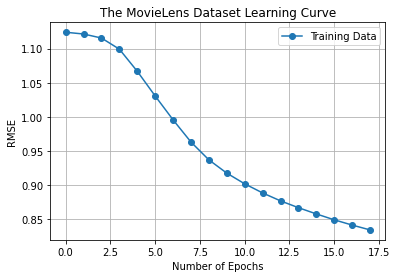

In [54]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [55]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K

cv_patk = CrossValidation('P@K')
cv_R_prec = CrossValidation('RPrecision')
cv_rmse = CrossValidation('RMSE')
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
patk_results = cv_patk.run(algorithm_instances, num_users, num_items,k=5).items()
R_prec_results = cv_R_prec.run(algorithm_instances, num_users, num_items,k=5).items()
rmse_results = cv_rmse.run(algorithm_instances, num_users, num_items,k=5).items()

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3172.50it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3206.01it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3210.30it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3233.59it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3168.24it/s]


Processing algorithm useraverage


20000it [00:06, 3176.20it/s]
20000it [00:06, 3205.05it/s]
20000it [00:06, 3211.36it/s]
20000it [00:06, 3253.75it/s]
20000it [00:06, 3209.27it/s]


Processing algorithm user-cosine


20000it [00:06, 3205.71it/s]
20000it [00:06, 3273.73it/s]
20000it [00:06, 3203.52it/s]
20000it [00:06, 3199.29it/s]
20000it [00:06, 3217.96it/s]


Processing algorithm item-cosine


20000it [00:06, 3214.06it/s]
20000it [00:06, 3122.15it/s]
20000it [00:06, 3237.21it/s]
20000it [00:06, 3226.20it/s]
20000it [00:06, 3175.42it/s]


Processing algorithm PMF


20000it [00:11, 1730.46it/s]
20000it [00:11, 1741.02it/s]
20000it [00:11, 1743.84it/s]
20000it [00:11, 1761.11it/s]
20000it [00:11, 1724.70it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3223.25it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3211.66it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3189.58it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3232.84it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3205.94it/s]


Processing algorithm useraverage


20000it [00:06, 3218.06it/s]
20000it [00:06, 3259.80it/s]
20000it [00:06, 3271.00it/s]
20000it [00:06, 3169.78it/s]
20000it [00:06, 3205.60it/s]


Processing algorithm user-cosine


20000it [00:06, 3210.75it/s]
20000it [00:06, 3219.04it/s]
20000it [00:06, 3226.80it/s]
20000it [00:06, 3195.29it/s]
20000it [00:06, 3196.26it/s]


Processing algorithm item-cosine


20000it [00:06, 3201.48it/s]
20000it [00:06, 3190.95it/s]
20000it [00:06, 3204.31it/s]
20000it [00:06, 3200.43it/s]
20000it [00:06, 3198.98it/s]


Processing algorithm PMF


20000it [00:11, 1711.72it/s]
20000it [00:11, 1729.95it/s]
20000it [00:11, 1740.82it/s]
20000it [00:11, 1718.09it/s]
20000it [00:11, 1715.03it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3169.43it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3175.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3217.00it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3250.40it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3180.43it/s]


Processing algorithm useraverage


20000it [00:06, 3231.80it/s]
20000it [00:06, 3241.98it/s]
20000it [00:06, 3220.53it/s]
20000it [00:06, 3188.92it/s]
20000it [00:06, 3229.78it/s]


Processing algorithm user-cosine


20000it [00:06, 3196.27it/s]
20000it [00:06, 3194.15it/s]
20000it [00:06, 3195.93it/s]
20000it [00:06, 3178.43it/s]
20000it [00:06, 3203.11it/s]


Processing algorithm item-cosine


20000it [00:06, 3217.13it/s]
20000it [00:06, 3201.91it/s]
20000it [00:06, 3208.75it/s]
20000it [00:06, 3147.39it/s]
20000it [00:06, 3193.15it/s]


Processing algorithm PMF


20000it [00:11, 1730.78it/s]
20000it [00:11, 1734.21it/s]
20000it [00:11, 1756.03it/s]
20000it [00:11, 1747.84it/s]
20000it [00:11, 1740.57it/s]


In [56]:
print('RMSE')
print('Method \t Mean \t CI')
for k, v  in rmse_results:
    print('{0}\t{1}\t({2}, {3})'.format(k, v[1], v[2], v[3]))
   

print('P@K')
print('Method \t Mean \t CI')
for k, v  in patk_results:
    print('{0}\t{1}\t({2}, {3})'.format(k, v[1], v[2], v[3]))
  

print('RPrecision')
print('Method \t Mean \t CI')
for k, v  in R_prec_results:
    print('{0}\t{1}\t({2}, {3})'.format(k, v[1], v[2], v[3]))

RMSE
Method 	 Mean 	 CI
popularity	3.1590928909890112	(3.139292746995387, 3.1788930349826354)
useraverage	1.0437176561595025	(1.0289303496379316, 1.0585049626810734)
user-cosine	1.017354121469863	(1.0090130800118484, 1.0256951629278774)
item-cosine	1.020082900106248	(1.0068242686250732, 1.0333415315874226)
PMF	0.9408928459576353	(0.9250092271208233, 0.9567764647944473)
P@K
Method 	 Mean 	 CI
popularity	0.5505832449628855	(0.40544114481568705, 0.6957253451100839)
useraverage	0.4736373276776259	(0.3419993013451059, 0.6052753540101459)
user-cosine	0.5558430540827157	(0.40959849499983714, 0.7020876131655943)
item-cosine	0.5322163308589621	(0.3837005215009889, 0.6807321402169354)
PMF	0.5572852598091208	(0.41192441778451194, 0.7026461018337297)
RPrecision
Method 	 Mean 	 CI
popularity	0.7176664506052826	(0.7068236314882174, 0.7285092697223478)
useraverage	0.6457304920247127	(0.6396305850946756, 0.6518303989547497)
user-cosine	0.7210187903610459	(0.7099951520220996, 0.7320424286999921)
item-c

### (b)

In [ ]:
"""we should not evaluate the popularity prediction by using RMSE. Our baseline popularity prediction is not calculated based on the similarities between 
users and items. As a result, calculating distance among popularity does not make sense. Also, for the vector user_liked, we only have 0 and 1 which is different
than other vectors."""

'we should not evaluate the popularity prediction by using RMSE. Our baseline popularity prediction is not calculated based on the similarities between \nusers and items. As a result, calculating distance among popularity does not make sense. Also, for the vector user_liked, we only have 0 and 1 which is different\nthan other vectors.'

### (c)

RMSE: PMF. Since PMF uses gradient descent to update its weights on each epoch based on the error(loss) between prdiction result and actual result, which is similar to RMSE, since RMSE calculates the root mean square error which is very similar to PMF as it also calculates the difference between prediction and actual result. 

P@K: PMF. Similar to RMSE, PMF is still the best algorithm since it constantly updates its weights on each epoch and therefore minimize the distance between prediction result and actual result. As a result, Using PMF to rank the results minimized the error which means more precise results(smaller errors) are returned first.

R@K:user-cosine. User-cosine performs slightly better than PMF, but User-cosine
algorithm is more personalized rather than generalized like PMF since User-cosine calculates similarity directly by comparing popularity and useraverage based the angle between vectors.



### (d)

Good performance on RMSE implies good ranking, but not vice versa. Since RMSE treats every rating equally. As a result, RMSE is prone to be affected by outliers. RMSE also measures classification precision. So, with a very small RMSE, we are very likely to get precise result, therefore having a good ranking. but ranking focuses on items with higher score which means even with bad RMSE performance, it's still very likely to performe a good ranking.

## Q6

### (a)

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#three movies chosen:'Orlando (1993)','Jurassic Park (1993)','With Honors (1994)',
movie_title1 =moviesDF.loc[moviesDF['movieTitle']=='Orlando (1993)']
movie_title2 =moviesDF.loc[moviesDF['movieTitle']=='Jurassic Park (1993)']
movie_title3 =moviesDF.loc[moviesDF['movieTitle']=='With Honors (1994)']
movie_id1=int(movie_title1['movieID'])
movie_id2=int(movie_title2['movieID'])
movie_id3=int(movie_title3['movieID'])
moive_ids=[]
moive_ids.append(movie_id1)
moive_ids.append(movie_id2)
moive_ids.append(movie_id3)
#print(movie_id1)
#print(movie_id2)
#print(movie_id3)
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
ii_similarity = SimBasedRecSys.cosine(train_matrix.transpose())

for movie_id in moive_ids:
 ii_vector = ii_similarity[movie_id] 
 idx = np.argsort(ii_vector)[::-1][0:6] 

 movie_itself=moviesDF.loc[moviesDF['movieID']==idx[0]]
 top_5_movie_title1 = moviesDF.loc[moviesDF['movieID']==idx[1]]
 top_5_movie_title2 = moviesDF.loc[moviesDF['movieID']==idx[2]]
 top_5_movie_title3 = moviesDF.loc[moviesDF['movieID']==idx[3]]
 top_5_movie_title4 = moviesDF.loc[moviesDF['movieID']==idx[4]]
 top_5_movie_title5 = moviesDF.loc[moviesDF['movieID']==idx[5]]
 print("\n\n top 5 movies for",movie_itself,"are: \n\n\n",top_5_movie_title1,top_5_movie_title2,top_5_movie_title3,top_5_movie_title4,top_5_movie_title5 ,"\n\n\"end for this movie!" )



 top 5 movies for      movieID      movieTitle  releaseDate  ...  thriller war  western
960      961  Orlando (1993)  01-Jan-1993  ...         0   0        0

[1 rows x 24 columns] are: 


       movieID         movieTitle  releaseDate  ...  thriller war  western
1209     1210  Virtuosity (1995)  01-Jan-1995  ...         1   0        0

[1 rows x 24 columns]      movieID             movieTitle  releaseDate  ...  thriller war  western
954      955  Before Sunrise (1995)  01-Jan-1995  ...         0   0        0

[1 rows x 24 columns]      movieID          movieTitle  releaseDate  ...  thriller war  western
809      810  Shadow, The (1994)  01-Jan-1994  ...         0   0        0

[1 rows x 24 columns]       movieID                                 movieTitle  ... war  western
1098     1099  Red Firecracker, Green Firecracker (1994)  ...   0        0

[1 rows x 24 columns]       movieID          movieTitle  releaseDate  ...  thriller war  western
1637     1638  Normal Life (1996)  25-Oct

### (b)

In [ ]:
"""We can use the genre of the movie to justify the similarities as most of the 
movies returned are in the same genre, despite the fact that the similarity is 
determined indirectly by the users."""

'We can use the genre of the movie to justify the similarities as most of the \nmovies returned are in the same genre, despite the fact that the similarity is \ndetermined indirectly by the users.'

## Q7

### (a)

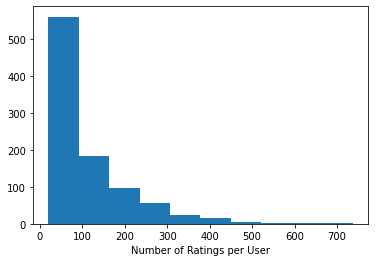

In [ ]:
import matplotlib.pyplot as plt
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
#print(temp_matrix.shape)
#print(train_matrix.shape)
num_rated_vector = np.sum(temp_matrix, axis =1) #temp_matrix 943*1682, summing over how many reviews given per user
#print(num_rated_vector)
plt.hist(num_rated_vector)
plt.xlabel('Number of Ratings per User')
plt.show()

We will pick threshold=80

In [ ]:
def predict_q7(base,train_matrix):
        
    if base == 'user':
            ########### your code goes here ###########
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
                # UxI: UxU mul UxI
        normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
        normalizer[normalizer == 0] = 1e-5
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        return predictionMatrix
            ###########         end         ###########
            
    elif base == 'item':
            ########### your code goes here ###########
        train_matrix = train_matrix.transpose() #(943, 1682) to 1682,943
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer==0] = 1e-5
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
        itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
        return predictionMatrix.transpose()


            ###########         end         ###########
def rmse_q7(pred, true):
    predItems = pred[true.nonzero()]
    trueItems = true[true.nonzero()]
    return sqrt(mean_squared_error(predItems, trueItems))

In [ ]:
above_threshold = train_matrix[num_rated_vector >= 80]
below_threshold = train_matrix[num_rated_vector < 80]
rmse_user_above_threshold = rmse_q7(predict_q7('user', above_threshold), above_threshold)
rmse_item_above_threshold = rmse_q7(predict_q7('item', above_threshold), above_threshold)
rmse_user_below_threshold = rmse_q7(predict_q7('user', below_threshold), below_threshold)
rmse_item_below_threshold = rmse_q7(predict_q7('item', below_threshold), below_threshold)
print('threshold is >=80 ratings \n','rmse_user_above_threshold', rmse_user_above_threshold,'\n','rmse_item_above_threshold',rmse_item_above_threshold,'\n', 'rmse_user_below_threshold', rmse_user_below_threshold,'\n','rmse_item_below_threshold',rmse_item_below_threshold )

threshold is >=80 ratings 
 rmse_user_above_threshold 0.9462725403756884 
 rmse_item_above_threshold 0.9906852995662324 
 rmse_user_below_threshold 0.8869019717445308 
 rmse_item_below_threshold 0.8896204910393178


For both cases, performances are better for users having less than 80 ratings. It means that it's easier to predict users who rated less movies, and harder to predict users who rated more movies. A possible explanation is that users who rated less movies watched less movies and they might have perfence over a certain genre which makes them easier to predict. On the other hand, users who rated more movies might watche more movies and therefore they might not have a perfrence for a certain genre. As a result, it's harder to predict their opinions.

## Q8

In [ ]:

import scipy.sparse as sp
from scipy.sparse.linalg import svds
class CompetitionRecSys(object):
    """
    You can define new methods if you need. Don't use global variables in the class. 
    """
    def __init__(self, ):
        """
        Initialization of the class
        1. Make sure to fill out self.pred_column_name, the name you give  to your competition method
        
        """
        ########## your code goes here ###########
        self.pred_column_name = 'Cosine_similarity'
        ###########         end         ###########
    @staticmethod
    def cosine_q8(matrix):
        """
            cosine similarity
        """
        #similarity_matrix=1/(1+pairwise_distances(matrix, metric='manhattan'))
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return... 
        
        NOTES:
            This function is where you train your model
        """
                
        ########## your code goes here ###########
        
        train_matrix = dataPreprocessor(train_vec, num_users, num_items)
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        uu_similarity = self.cosine_q8(train_matrix)
        # UxI: UxU mul UxI
        normalizer = np.matmul(uu_similarity, temp_matrix)
        #print(normalizer)
        normalizer[normalizer == 0] = 1e-5
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
        #print(columns.shape)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        self.__model = predictionMatrix
        
        '''
        ########### your code goes here ###########
        
        train_matrix = dataPreprocessor(train_vec, num_users, num_items)
        train_matrix = train_matrix.transpose() #(943, 1682) to 1682,943
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        ii_similarity = self.cosine_q8(train_matrix)
        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer==0] = 1e-5
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
        itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
        #print(columns.shape)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
        self.__model = predictionMatrix.transpose() #1682,943 back to 943,1682
         '''
        ###########         end         ###########

        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction 
            Please fill out: prediction.loc[index, self.pred_column_name] = None                            
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            ########### your code goes here ###########
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
            ###########         end         ###########

        return prediction
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        ########### your code goes here ###########
        self.__model=None
        ##########         end         ###########



In [ ]:
competition = CompetitionRecSys()
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances, num_users, num_items)


Processing algorithm Cosine_similarity


20000it [00:05, 3416.27it/s]
20000it [00:06, 3292.44it/s]
20000it [00:07, 2677.90it/s]
20000it [00:05, 3400.07it/s]
20000it [00:05, 3357.75it/s]


In [ ]:
print(rp)

{'Cosine_similarity': [[0.7177834541075783, 0.7127674206396806, 0.7152791599993573, 0.7243681832929256, 0.7348957337656873], 0.7210187903610459, 0.7099951520220996, 0.7320424286999921]}


# Validation

In [ ]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [ ]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [ ]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [ ]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [ ]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [ ]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [ ]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [ ]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [ ]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [ ]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [ ]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [ ]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [ ]:
validatePMFRecSys(validation_df=validation_df)